<a href="https://colab.research.google.com/github/younus8imran/MyProjects/blob/master/FashionMnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with pytorch using FashionMNIST dataset

In [110]:
# importing all the necessary libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

In [111]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [112]:
# Hyper parameters
num_epochs = 10
num_classes = 10
batch_size = 150
learning_rate = 0.001

In [113]:
# FashionMNIST dataset
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor)
train_dataset = FashionMNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = FashionMNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

In [114]:
# Data loader
train_loader = DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

images.shape: torch.Size([150, 1, 28, 28])


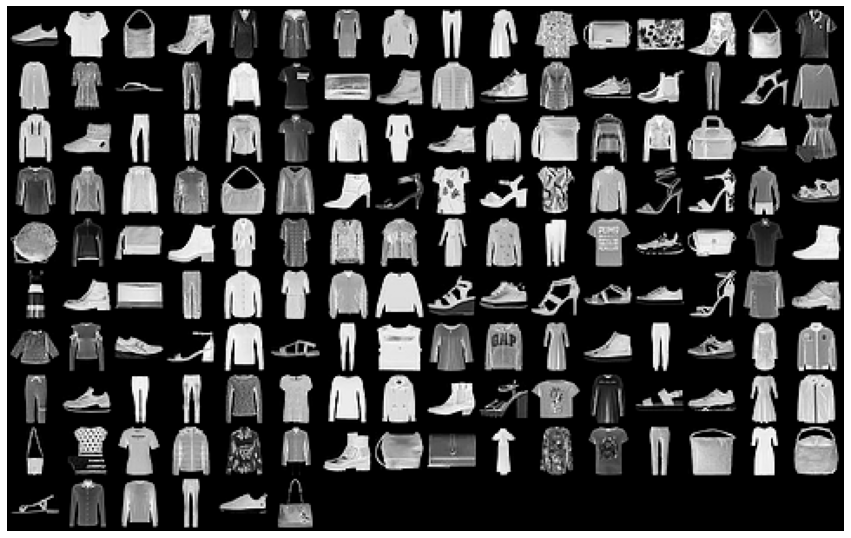

In [115]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [116]:
# Convolutional neural network (two convolutional layers)
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # input shape: (None,1,28,28)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), #output shape: (None,16,28,28)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,16,14,14)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), #output shape: (None,32,14,14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,32,7,7)
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        # input shape: (None,1,28,28)
        out = self.layer1(x) #output shape: (None,16,14,14)
        out = self.layer2(out) #output shape: (None,32,7,7)
        """The reshape function also consider the 0th, i.e. batch dimension, different from Keras.Reshape!"""
        out = out.reshape(out.size(0), -1) #output shape: (None,32*7*7)
        out = self.fc(out) #output shape: (None,10)
        return out

In [117]:
model = CNN(num_classes).to(device)

In [118]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [119]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        """PyTorch is channel first, different from TensorFlow!"""
        """images.size(): torch.Size([100, 1, 28, 28])"""
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/400], Loss: 0.4088
Epoch [1/10], Step [200/400], Loss: 0.3850
Epoch [1/10], Step [300/400], Loss: 0.3661
Epoch [1/10], Step [400/400], Loss: 0.3198
Epoch [2/10], Step [100/400], Loss: 0.3043
Epoch [2/10], Step [200/400], Loss: 0.2637
Epoch [2/10], Step [300/400], Loss: 0.2645
Epoch [2/10], Step [400/400], Loss: 0.2985
Epoch [3/10], Step [100/400], Loss: 0.3674
Epoch [3/10], Step [200/400], Loss: 0.1802
Epoch [3/10], Step [300/400], Loss: 0.2055
Epoch [3/10], Step [400/400], Loss: 0.2575
Epoch [4/10], Step [100/400], Loss: 0.2756
Epoch [4/10], Step [200/400], Loss: 0.1381
Epoch [4/10], Step [300/400], Loss: 0.3450
Epoch [4/10], Step [400/400], Loss: 0.2608
Epoch [5/10], Step [100/400], Loss: 0.2301
Epoch [5/10], Step [200/400], Loss: 0.1487
Epoch [5/10], Step [300/400], Loss: 0.2279
Epoch [5/10], Step [400/400], Loss: 0.1979
Epoch [6/10], Step [100/400], Loss: 0.1706
Epoch [6/10], Step [200/400], Loss: 0.1651
Epoch [6/10], Step [300/400], Loss: 0.1391
Epoch [6/10

In [120]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
# has effect on specific layers like Dropout and BatchNorm
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #Tensor.data: tensor
        _, predicted = torch.max(outputs.data, 1)
        #Tensor.size(): torch.Size, Tensor.size(0): int
        total += labels.size(0)
        #Tensor.item(): number
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.33 %


In [121]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [122]:
def predict_image(img, model):
    xb = (img.unsqueeze(0)).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: T-shirt/top , Predicted: T-shirt/top


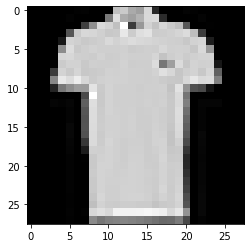

In [129]:
img, label = test_dataset[85]
plt.imshow(img[0], cmap='gray')
print("Label:", dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])